## Kaggle Competition: Tabular Playground Series (Feb 2021)

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

## Load Data

#### Data Description

For this competition, you will be predicting a continuous `target` based on a number of feature columns given in the data. All of the feature columns, `cat0` - `cat9` are categorical, and the feature columns `cont0` - `cont13` are continuous.


#### Files

- train.csv - the training data with the `target` column
- test.csv - the test set; you will be predicting the `target` for each row in this file
- sample_submission.csv - a sample submission file in the correct format

In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [63]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,A,B,A,C,B,D,A,E,E,...,0.701679,0.595507,0.286912,0.279884,0.202234,0.242654,0.285147,0.264308,0.653654,0.302448
1,5,A,B,A,C,B,D,A,E,C,...,0.277480,0.479552,0.397436,0.476742,0.857073,0.516393,0.562065,0.730542,0.318492,0.736251
2,15,A,B,A,C,B,D,A,E,C,...,0.279508,0.676395,0.695284,0.253316,0.586934,0.548555,0.836193,0.759788,0.333572,0.273905
3,16,A,A,B,A,B,D,A,E,E,...,0.479503,0.759875,0.240049,0.298074,0.442475,0.596746,0.414131,0.255382,0.589080,0.311625
4,17,A,B,A,A,B,B,A,E,E,...,0.757845,0.210232,0.329851,0.616663,0.170475,0.263235,0.710961,0.224045,0.285860,0.794931


## Data Preparation

### Check for duplicates

In [3]:
print(len(train_df))
train_df = train_df.drop_duplicates()
print(len(train_df))

300000
300000


### Check for missing values

In [4]:
train_df.isnull().sum().sort_values(ascending=False)

id        0
cat0      0
cont13    0
cont12    0
cont11    0
cont10    0
cont9     0
cont8     0
cont7     0
cont6     0
cont5     0
cont4     0
cont3     0
cont2     0
cont1     0
cont0     0
cat9      0
cat8      0
cat7      0
cat6      0
cat5      0
cat4      0
cat3      0
cat2      0
cat1      0
target    0
dtype: int64

### Check for outliers

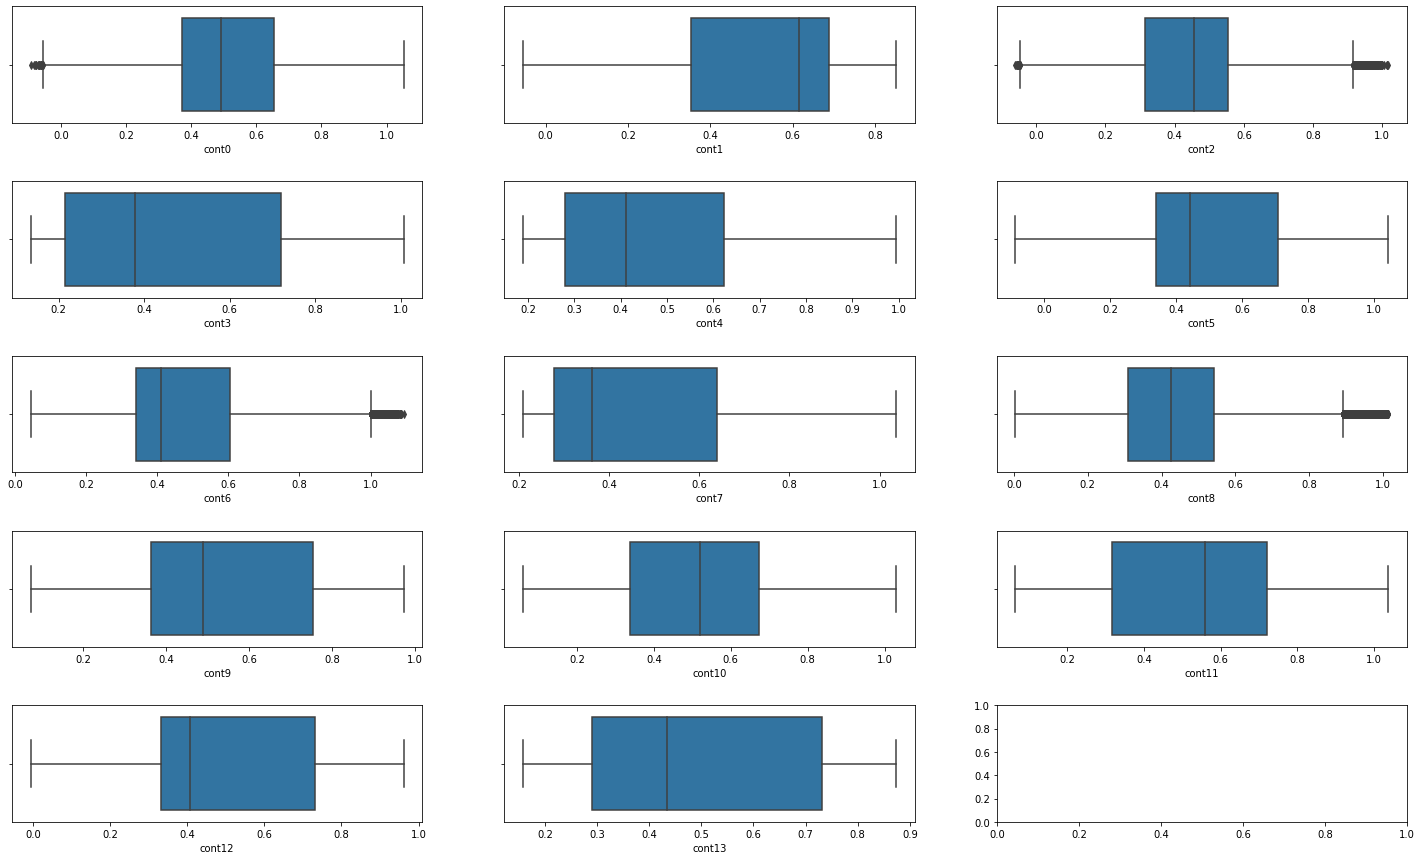

In [5]:
fig, axes = plt.subplots(5, 3, figsize=(25, 15))
sns.boxplot(x='cont0', data=train_df, ax=axes[0,0])
sns.boxplot(x='cont1', data=train_df, ax=axes[0,1])
sns.boxplot(x='cont2', data=train_df, ax=axes[0,2])
sns.boxplot(x='cont3', data=train_df, ax=axes[1,0])
sns.boxplot(x='cont4', data=train_df, ax=axes[1,1])
sns.boxplot(x='cont5', data=train_df, ax=axes[1,2])
sns.boxplot(x='cont6', data=train_df, ax=axes[2,0])
sns.boxplot(x='cont7', data=train_df, ax=axes[2,1])
sns.boxplot(x='cont8', data=train_df, ax=axes[2,2])
sns.boxplot(x='cont9', data=train_df, ax=axes[3,0])
sns.boxplot(x='cont10', data=train_df, ax=axes[3,1])
sns.boxplot(x='cont11', data=train_df, ax=axes[3,2])
sns.boxplot(x='cont12', data=train_df, ax=axes[4,0])
sns.boxplot(x='cont13', data=train_df, ax=axes[4,1])
fig.subplots_adjust(hspace=0.5)
plt.show()

--------------------

*Count of outliers on the low side for cont0 and cont2 are less than 1% of the data. However the up side outliers for cont2, cont6, and cont8 are signficant so opting not to drop outliers. Use robust scaler on cont0, cont2, cont6, and cont8. Use MinMax scaler for remaining continuous features.*

-----------------

### Scale continuous features

In [6]:
train_df.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5',
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'target'],
      dtype='object')

In [7]:
robust = ['cont0', 'cont2', 'cont6', 'cont8']
min_max = ['cont1', 'cont3', 'cont4', 'cont5', 'cont7', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']

In [8]:
r_scaler = RobustScaler() 
r_scaler.fit(train_df[robust])
train_df[robust] = r_scaler.transform(train_df[robust])
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.043732,0.741413,2.018280,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,-0.241574,0.278495,0.719764,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,-0.153161,0.832564,1.888681,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.638699,0.407313,1.899329,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,1.119159,0.325193,0.065125,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [9]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(train_df[min_max])
train_df[min_max] = mm_scaler.transform(train_df[min_max])
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.855691,0.043732,0.643496,2.018280,0.811322,0.685241,0.654854,0.913387,0.785206,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.465907,-0.241574,0.084307,0.719764,0.526128,0.570654,0.695283,0.343629,0.908989,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.884880,-0.153161,0.753604,1.888681,0.836672,0.210755,0.648330,0.904611,0.936786,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.902538,0.638699,0.239914,1.899329,0.802359,0.448007,0.650962,0.843251,0.638256,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.415176,1.119159,0.140716,0.065125,0.432796,0.685273,0.635506,0.360980,0.195151,6.868974


### Encode categorical features

In [10]:
train_df.cat0.unique()

array(['A', 'B'], dtype=object)

In [11]:
ohe0 = OneHotEncoder(sparse = False) 
ohe0.fit(train_df[['cat0']])
cat0_encoded = ohe0.transform(train_df[['cat0']]) 
train_df['cat0_a'],train_df["cat0_b"] = cat0_encoded.T 
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,cat0_a,cat0_b
0,1,A,B,A,A,B,D,A,E,C,...,0.643496,2.018280,0.811322,0.685241,0.654854,0.913387,0.785206,6.994023,1.0,0.0
1,2,B,A,A,A,B,B,A,E,A,...,0.084307,0.719764,0.526128,0.570654,0.695283,0.343629,0.908989,8.071256,0.0,1.0
2,3,A,A,A,C,B,D,A,B,C,...,0.753604,1.888681,0.836672,0.210755,0.648330,0.904611,0.936786,5.760456,1.0,0.0
3,4,A,A,A,C,B,D,A,E,G,...,0.239914,1.899329,0.802359,0.448007,0.650962,0.843251,0.638256,7.806457,1.0,0.0
4,6,A,B,A,A,B,B,A,E,C,...,0.140716,0.065125,0.432796,0.685273,0.635506,0.360980,0.195151,6.868974,1.0,0.0


In [12]:
train_df.drop(columns='cat0', inplace=True)
train_df.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,cat0_a,cat0_b
0,1,B,A,A,B,D,A,E,C,I,...,0.643496,2.018280,0.811322,0.685241,0.654854,0.913387,0.785206,6.994023,1.0,0.0
1,2,A,A,A,B,B,A,E,A,F,...,0.084307,0.719764,0.526128,0.570654,0.695283,0.343629,0.908989,8.071256,0.0,1.0
2,3,A,A,C,B,D,A,B,C,N,...,0.753604,1.888681,0.836672,0.210755,0.648330,0.904611,0.936786,5.760456,1.0,0.0
3,4,A,A,C,B,D,A,E,G,K,...,0.239914,1.899329,0.802359,0.448007,0.650962,0.843251,0.638256,7.806457,1.0,0.0
4,6,B,A,A,B,B,A,E,C,F,...,0.140716,0.065125,0.432796,0.685273,0.635506,0.360980,0.195151,6.868974,1.0,0.0


In [13]:
train_df.cat1.unique()

array(['B', 'A'], dtype=object)

In [14]:
ohe1 = OneHotEncoder(sparse = False) 
ohe1.fit(train_df[['cat1']])
cat1_encoded = ohe1.transform(train_df[['cat1']]) 
train_df['cat1_a'],train_df["cat1_b"] = cat1_encoded.T 
train_df.drop(columns='cat1', inplace=True)
train_df.head()

,id,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,...,cont9,cont10,cont11,cont12,cont13,target,cat0_a,cat0_b,cat1_a,cat1_b
0,1,A,A,B,D,A,E,C,I,1.515719,...,0.811322,0.685241,0.654854,0.913387,0.785206,6.994023,1.0,0.0,0.0,1.0
1,2,A,A,B,B,A,E,A,F,-0.191956,...,0.526128,0.570654,0.695283,0.343629,0.908989,8.071256,0.0,1.0,1.0,0.0
2,3,A,C,B,D,A,B,C,N,0.844056,...,0.836672,0.210755,0.648330,0.904611,0.936786,5.760456,1.0,0.0,1.0,0.0
3,4,A,C,B,D,A,E,G,K,0.748864,...,0.802359,0.448007,0.650962,0.843251,0.638256,7.806457,1.0,0.0,1.0,0.0
4,6,A,A,B,B,A,E,C,F,-0.021612,...,0.432796,0.685273,0.635506,0.360980,0.195151,6.868974,1.0,0.0,0.0,1.0


In [15]:
train_df.cat2.unique()

array(['A', 'B'], dtype=object)

In [16]:
ohe2 = OneHotEncoder(sparse = False) 
ohe2.fit(train_df[['cat2']])
cat2_encoded = ohe2.transform(train_df[['cat2']]) 
train_df['cat2_a'],train_df["cat2_b"] = cat2_encoded.T 
train_df.drop(columns='cat2', inplace=True)
train_df.head()

,id,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,...,cont11,cont12,cont13,target,cat0_a,cat0_b,cat1_a,cat1_b,cat2_a,cat2_b
0,1,A,B,D,A,E,C,I,1.515719,0.816091,...,0.654854,0.913387,0.785206,6.994023,1.0,0.0,0.0,1.0,1.0,0.0
1,2,A,B,B,A,E,A,F,-0.191956,0.076438,...,0.695283,0.343629,0.908989,8.071256,0.0,1.0,1.0,0.0,1.0,0.0
2,3,C,B,D,A,B,C,N,0.844056,0.898964,...,0.648330,0.904611,0.936786,5.760456,1.0,0.0,1.0,0.0,1.0,0.0
3,4,C,B,D,A,E,G,K,0.748864,0.911708,...,0.650962,0.843251,0.638256,7.806457,1.0,0.0,1.0,0.0,1.0,0.0
4,6,A,B,B,A,E,C,F,-0.021612,0.765785,...,0.635506,0.360980,0.195151,6.868974,1.0,0.0,0.0,1.0,1.0,0.0


In [17]:
train_df.cat3.unique()

array(['A', 'C', 'D', 'B'], dtype=object)

In [18]:
ohe3 = OneHotEncoder(sparse = False) 
ohe3.fit(train_df[['cat3']])
cat3_encoded = ohe3.transform(train_df[['cat3']]) 
train_df['cat3_a'],train_df["cat3_b"], train_df["cat3_c"], train_df["cat3_d"] = cat3_encoded.T 
train_df.drop(columns='cat3', inplace=True)
train_df.head()

,id,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,...,cat0_a,cat0_b,cat1_a,cat1_b,cat2_a,cat2_b,cat3_a,cat3_b,cat3_c,cat3_d
0,1,B,D,A,E,C,I,1.515719,0.816091,-1.382623,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2,B,B,A,E,A,F,-0.191956,0.076438,-0.414735,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,3,B,D,A,B,C,N,0.844056,0.898964,-0.010912,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4,B,D,A,E,G,K,0.748864,0.911708,-1.260978,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,6,B,B,A,E,C,F,-0.021612,0.765785,0.161776,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [19]:
train_df.cat4.unique()

array(['B', 'C', 'A', 'D'], dtype=object)

In [20]:
ohe4 = OneHotEncoder(sparse = False) 
ohe4.fit(train_df[['cat4']])
cat4_encoded = ohe4.transform(train_df[['cat4']]) 
train_df['cat4_a'],train_df["cat4_b"], train_df["cat4_c"], train_df["cat4_d"] = cat4_encoded.T 
train_df.drop(columns='cat4', inplace=True)
train_df.head()

,id,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,...,cat2_a,cat2_b,cat3_a,cat3_b,cat3_c,cat3_d,cat4_a,cat4_b,cat4_c,cat4_d
0,1,D,A,E,C,I,1.515719,0.816091,-1.382623,0.095360,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,B,A,E,A,F,-0.191956,0.076438,-0.414735,0.816060,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,D,A,B,C,N,0.844056,0.898964,-0.010912,0.778047,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,4,D,A,E,G,K,0.748864,0.911708,-1.260978,0.686162,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,6,B,A,E,C,F,-0.021612,0.765785,0.161776,0.251719,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
train_df.cat5.unique()

array(['D', 'B', 'A', 'C'], dtype=object)

In [22]:
ohe5 = OneHotEncoder(sparse = False) 
ohe5.fit(train_df[['cat5']])
cat5_encoded = ohe5.transform(train_df[['cat5']]) 
train_df['cat5_a'],train_df["cat5_b"], train_df["cat5_c"], train_df["cat5_d"] = cat5_encoded.T 
train_df.drop(columns='cat5', inplace=True)
train_df.head()

,id,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,...,cat3_c,cat3_d,cat4_a,cat4_b,cat4_c,cat4_d,cat5_a,cat5_b,cat5_c,cat5_d
0,1,A,E,C,I,1.515719,0.816091,-1.382623,0.095360,0.114564,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,A,E,A,F,-0.191956,0.076438,-0.414735,0.816060,0.115723,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,A,B,C,N,0.844056,0.898964,-0.010912,0.778047,0.129890,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,A,E,G,K,0.748864,0.911708,-1.260978,0.686162,0.721352,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,A,E,C,F,-0.021612,0.765785,0.161776,0.251719,0.111686,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [23]:
train_df.cat6.unique()

array(['A', 'B', 'D', 'C', 'E', 'I', 'G', 'H'], dtype=object)

In [24]:
ohe6 = OneHotEncoder(sparse = False) 
ohe6.fit(train_df[['cat6']])
cat6_encoded = ohe6.transform(train_df[['cat6']]) 
train_df['cat6_a'],train_df["cat6_b"], train_df["cat6_c"], train_df["cat6_d"], train_df["cat6_e"], \
train_df["cat6_g"], train_df["cat6_h"], train_df["cat6_i"] = cat6_encoded.T 
train_df.drop(columns='cat6', inplace=True)
train_df.head()

,id,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,...,cat5_c,cat5_d,cat6_a,cat6_b,cat6_c,cat6_d,cat6_e,cat6_g,cat6_h,cat6_i
0,1,E,C,I,1.515719,0.816091,-1.382623,0.095360,0.114564,0.855691,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,E,A,F,-0.191956,0.076438,-0.414735,0.816060,0.115723,0.465907,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,B,C,N,0.844056,0.898964,-0.010912,0.778047,0.129890,0.884880,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,E,G,K,0.748864,0.911708,-1.260978,0.686162,0.721352,0.902538,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,E,C,F,-0.021612,0.765785,0.161776,0.251719,0.111686,0.415176,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
train_df.cat7.unique()

array(['E', 'B', 'D', 'G', 'F', 'A', 'C', 'I'], dtype=object)

In [26]:
ohe7 = OneHotEncoder(sparse = False) 
ohe7.fit(train_df[['cat7']])
cat7_encoded = ohe7.transform(train_df[['cat7']]) 
train_df['cat7_a'],train_df["cat7_b"], train_df["cat7_c"], train_df["cat7_d"], train_df["cat7_e"], \
train_df["cat7_f"], train_df["cat7_g"], train_df["cat7_i"] = cat7_encoded.T 
train_df.drop(columns='cat7', inplace=True)
train_df.head()

,id,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,...,cat6_h,cat6_i,cat7_a,cat7_b,cat7_c,cat7_d,cat7_e,cat7_f,cat7_g,cat7_i
0,1,C,I,1.515719,0.816091,-1.382623,0.095360,0.114564,0.855691,0.043732,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,A,F,-0.191956,0.076438,-0.414735,0.816060,0.115723,0.465907,-0.241574,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,C,N,0.844056,0.898964,-0.010912,0.778047,0.129890,0.884880,-0.153161,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,G,K,0.748864,0.911708,-1.260978,0.686162,0.721352,0.902538,0.638699,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,6,C,F,-0.021612,0.765785,0.161776,0.251719,0.111686,0.415176,1.119159,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
train_df.cat8.unique()

array(['C', 'A', 'G', 'E', 'D', 'F', 'B'], dtype=object)

In [28]:
ohe8 = OneHotEncoder(sparse = False) 
ohe8.fit(train_df[['cat8']])
cat8_encoded = ohe8.transform(train_df[['cat8']]) 
train_df['cat8_a'],train_df["cat8_b"], train_df["cat8_c"], train_df["cat8_d"], train_df["cat8_e"], \
train_df["cat8_f"], train_df["cat8_g"] = cat8_encoded.T 
train_df.drop(columns='cat8', inplace=True)
train_df.head()

,id,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,...,cat7_f,cat7_g,cat7_i,cat8_a,cat8_b,cat8_c,cat8_d,cat8_e,cat8_f,cat8_g
0,1,I,1.515719,0.816091,-1.382623,0.095360,0.114564,0.855691,0.043732,0.643496,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,F,-0.191956,0.076438,-0.414735,0.816060,0.115723,0.465907,-0.241574,0.084307,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,N,0.844056,0.898964,-0.010912,0.778047,0.129890,0.884880,-0.153161,0.753604,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,K,0.748864,0.911708,-1.260978,0.686162,0.721352,0.902538,0.638699,0.239914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,F,-0.021612,0.765785,0.161776,0.251719,0.111686,0.415176,1.119159,0.140716,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [34]:
train_df.cat9.unique()

array(['I', 'F', 'N', 'K', 'B', 'L', 'G', 'H', 'O', 'A', 'J', 'M', 'C',
       'D', 'E'], dtype=object)

In [35]:
ohe9 = OneHotEncoder(sparse = False) 
ohe9.fit(train_df[['cat9']])
cat9_encoded = ohe9.transform(train_df[['cat9']]) 
train_df['cat9_a'],train_df["cat9_b"], train_df["cat9_c"], train_df["cat9_d"], train_df["cat9_e"], \
train_df["cat9_f"], train_df["cat9_g"], train_df["cat9_h"], train_df["cat9_i"], train_df["cat9_j"], \
train_df["cat9_k"], train_df["cat9_l"], train_df["cat9_m"], train_df["cat9_n"], train_df["cat9_o"] = cat9_encoded.T 
train_df.drop(columns='cat9', inplace=True)
train_df.head()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,...,cat9_f,cat9_g,cat9_h,cat9_i,cat9_j,cat9_k,cat9_l,cat9_m,cat9_n,cat9_o
0,1,1.515719,0.816091,-1.382623,0.095360,0.114564,0.855691,0.043732,0.643496,2.018280,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,-0.191956,0.076438,-0.414735,0.816060,0.115723,0.465907,-0.241574,0.084307,0.719764,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.844056,0.898964,-0.010912,0.778047,0.129890,0.884880,-0.153161,0.753604,1.888681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,0.748864,0.911708,-1.260978,0.686162,0.721352,0.902538,0.638699,0.239914,1.899329,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6,-0.021612,0.765785,0.161776,0.251719,0.111686,0.415176,1.119159,0.140716,0.065125,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature selection

#### Check for correlation

<AxesSubplot:>

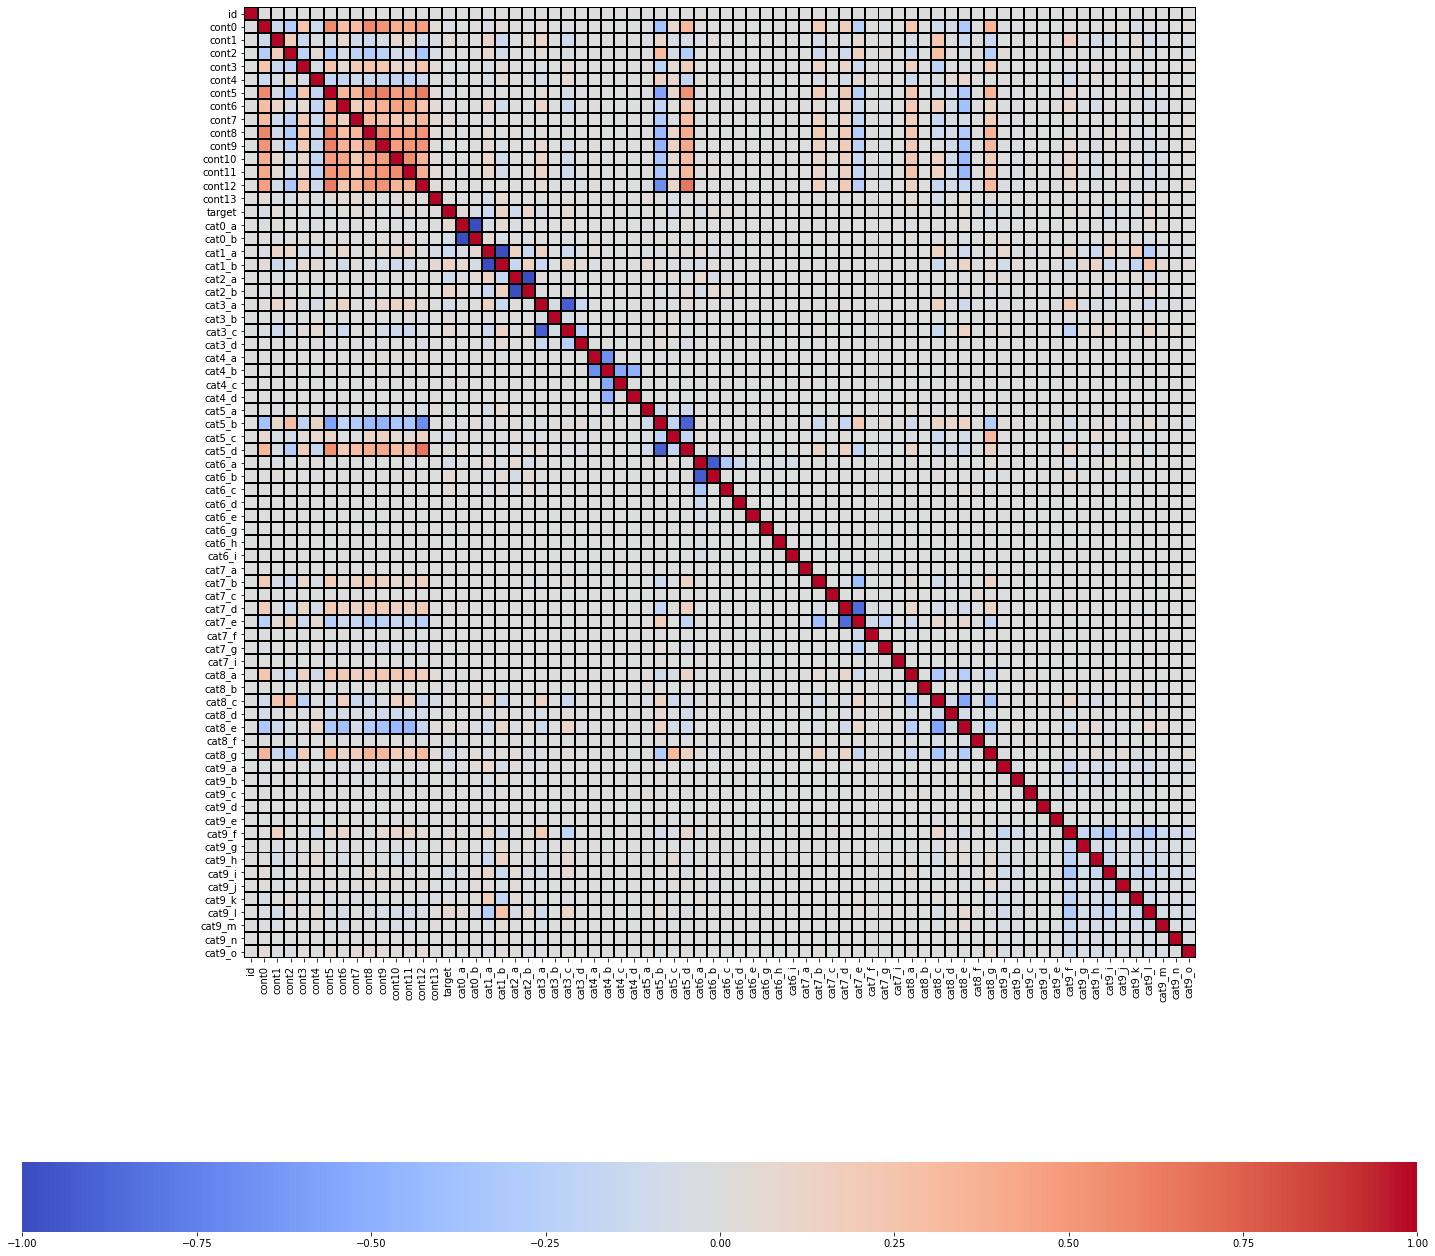

In [42]:
corr = train_df.corr()
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        ax=ax, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',
        linewidths=1, linecolor='black',
        cbar_kws= {'orientation': 'horizontal'}, 
        square=True)

In [44]:
corr_df = corr.unstack().reset_index()
corr_df.columns = ['feature_1','feature_2', 'correlation']
corr_df.sort_values(by="correlation",ascending=False, inplace=True)
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
969,cont12,cat5_d,0.659916
2389,cat5_d,cont12,0.659916
942,cont12,cont5,0.631926
445,cont5,cont12,0.631926
726,cont9,cont5,0.615836


-----------

*The highest feature correlation is ~0.66. Since there aren't many strongly correlated features (over 0.8), I decided to keep all of features based on correlation and check feature importance*

---------------

#### Check feature importance

In [59]:
X = train_df.drop(columns='target')
y = train_df.target

In [52]:
model = LinearRegression() 
scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error') # Cross validate
scores.mean()

-0.8637482861250723

In [50]:
model = LinearRegression().fit(X, y)
permutation_score = permutation_importance(model, X, y)
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False)

,feature,score decrease
9,cont8,0.011589
1,cont0,0.00901
6,cont5,0.007568
12,cont11,0.0071
55,cat8_g,0.004995
...,...,...
41,cat7_a,0.000001
25,cat4_a,0.0
0,id,0.0
68,cat9_m,-0.0


In [53]:
weak_df = importance_df.sort_values(by="score decrease", ascending = True).head(16)
weak_df

,feature,score decrease
50,cat8_b,-0.0
68,cat9_m,-0.0
0,id,0.0
25,cat4_a,0.0
41,cat7_a,0.000001
38,cat6_g,0.000001
39,cat6_h,0.000001
46,cat7_f,0.000001
36,cat6_d,0.000001
43,cat7_c,0.000002


In [54]:
weak_df.feature.unique()

array(['cat8_b', 'cat9_m', 'id', 'cat4_a', 'cat7_a', 'cat6_g', 'cat6_h',
       'cat7_f', 'cat6_d', 'cat7_c', 'cat9_n', 'cat9_c', 'cat6_i',
       'cat9_d', 'cat9_k', 'cat6_e'], dtype=object)

In [60]:
X = X.drop(columns=['cat8_b', 'cat9_m', 'id', 'cat4_a', 'cat7_a', 'cat6_g', 'cat6_h',
       'cat7_f', 'cat6_d', 'cat7_c', 'cat9_n', 'cat9_c', 'cat6_i',
       'cat9_d', 'cat9_k', 'cat6_e'])
model = LinearRegression() 
scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error') # Cross validate
scores.mean()
X.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_a,cat9_b,cat9_e,cat9_f,cat9_g,cat9_h,cat9_i,cat9_j,cat9_l,cat9_o
0,1.515719,0.816091,-1.382623,0.095360,0.114564,0.855691,0.043732,0.643496,2.018280,0.811322,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191956,0.076438,-0.414735,0.816060,0.115723,0.465907,-0.241574,0.084307,0.719764,0.526128,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.844056,0.898964,-0.010912,0.778047,0.129890,0.884880,-0.153161,0.753604,1.888681,0.836672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.748864,0.911708,-1.260978,0.686162,0.721352,0.902538,0.638699,0.239914,1.899329,0.802359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.021612,0.765785,0.161776,0.251719,0.111686,0.415176,1.119159,0.140716,0.065125,0.432796,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
strong_df = importance_df.sort_values(by="score decrease", ascending = False).head(16)
strong_df

,feature,score decrease
9,cont8,0.011589
1,cont0,0.00901
6,cont5,0.007568
12,cont11,0.0071
55,cat8_g,0.004995
18,cat1_b,0.004431
17,cat1_a,0.004431
64,cat9_i,0.003828
67,cat9_l,0.00362
2,cont1,0.003187


In [57]:
strong_df.feature.unique()

array(['cont8', 'cont0', 'cont5', 'cont11', 'cat8_g', 'cat1_b', 'cat1_a',
       'cat9_i', 'cat9_l', 'cont1', 'cat5_b', 'cat2_a', 'cat2_b',
       'cat3_a', 'cat7_e', 'cat5_d'], dtype=object)

In [58]:
# X = X[['cont8', 'cont0', 'cont5', 'cont11', 'cat8_g', 'cat1_b', 'cat1_a',
#        'cat9_i', 'cat9_l', 'cont1', 'cat5_b', 'cat2_a', 'cat2_b',
#        'cat3_a', 'cat7_e', 'cat5_d']]
# model = LinearRegression() 
# scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error') # Cross validate
# scores.mean()

-0.867446007690982

------------

*Tried dropping 20% weakest features vs. keeping 20% strongest features. Too much information is lost with option B so going with dropping 20% weakest features.*

-----------

In [62]:
# Save progress

X.to_csv('data/X_train.csv', index=False)
y.to_csv('data/y_train.csv', index=False)

### Complete same steps on test data

In [64]:
# Check for duplicates

print(len(test_df))
test_df = test_df.drop_duplicates()
print(len(test_df))

200000
200000


In [65]:
# Check for missing values

test_df.isnull().sum().sort_values(ascending=False)

id        0
cont2     0
cont12    0
cont11    0
cont10    0
cont9     0
cont8     0
cont7     0
cont6     0
cont5     0
cont4     0
cont3     0
cont1     0
cat0      0
cont0     0
cat9      0
cat8      0
cat7      0
cat6      0
cat5      0
cat4      0
cat3      0
cat2      0
cat1      0
cont13    0
dtype: int64

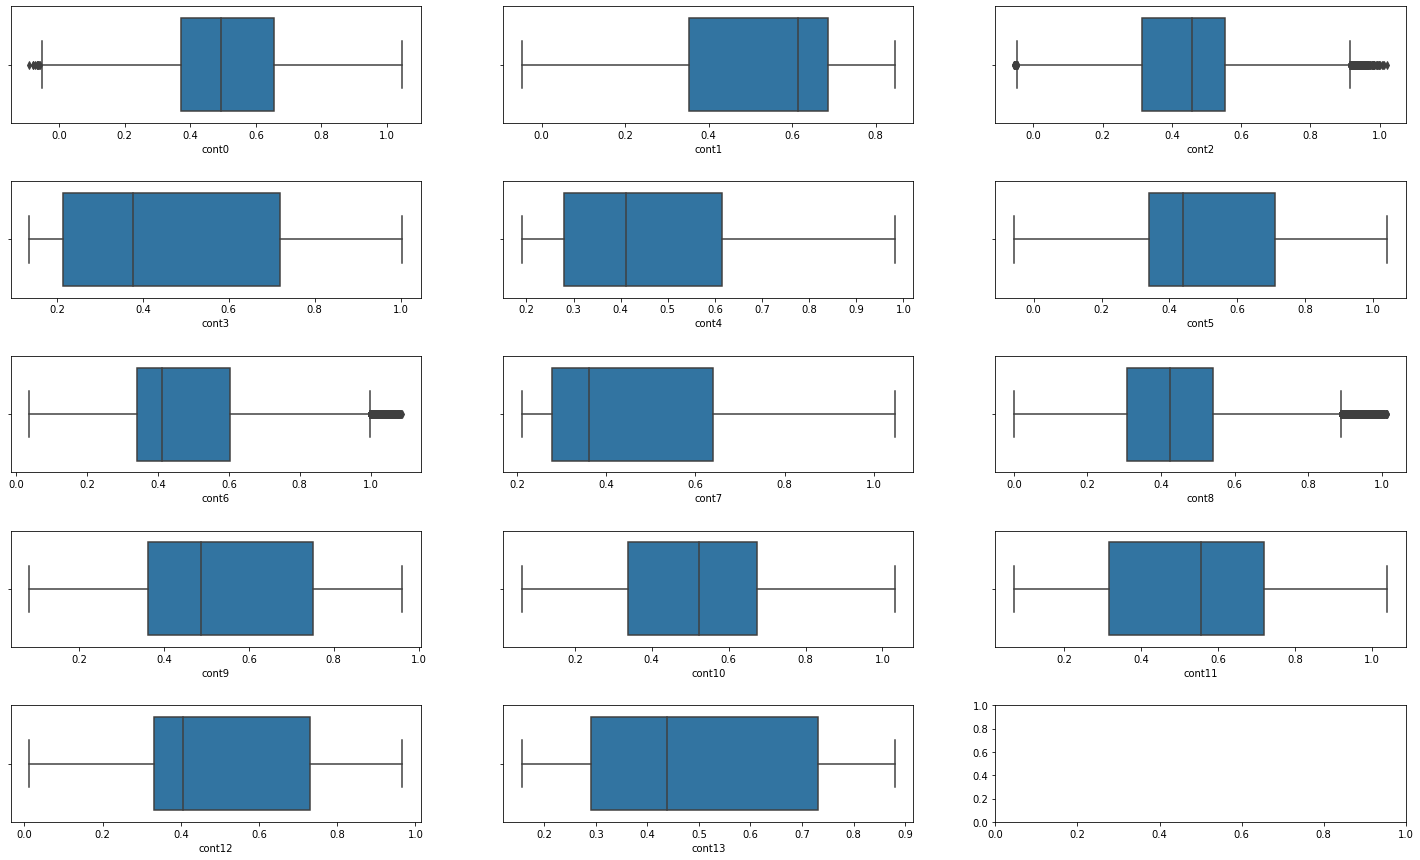

In [66]:
# Check for outliers

fig, axes = plt.subplots(5, 3, figsize=(25, 15))
sns.boxplot(x='cont0', data=test_df, ax=axes[0,0])
sns.boxplot(x='cont1', data=test_df, ax=axes[0,1])
sns.boxplot(x='cont2', data=test_df, ax=axes[0,2])
sns.boxplot(x='cont3', data=test_df, ax=axes[1,0])
sns.boxplot(x='cont4', data=test_df, ax=axes[1,1])
sns.boxplot(x='cont5', data=test_df, ax=axes[1,2])
sns.boxplot(x='cont6', data=test_df, ax=axes[2,0])
sns.boxplot(x='cont7', data=test_df, ax=axes[2,1])
sns.boxplot(x='cont8', data=test_df, ax=axes[2,2])
sns.boxplot(x='cont9', data=test_df, ax=axes[3,0])
sns.boxplot(x='cont10', data=test_df, ax=axes[3,1])
sns.boxplot(x='cont11', data=test_df, ax=axes[3,2])
sns.boxplot(x='cont12', data=test_df, ax=axes[4,0])
sns.boxplot(x='cont13', data=test_df, ax=axes[4,1])
fig.subplots_adjust(hspace=0.5)
plt.show()

In [67]:
# Scale continuous features - robust scaler

r_scaler = RobustScaler() 
r_scaler.fit(test_df[robust])
test_df[robust] = r_scaler.transform(test_df[robust])
test_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,A,B,A,C,B,D,A,E,E,...,0.701679,0.595507,-0.467832,0.279884,-0.960400,0.242654,0.285147,0.264308,0.653654,0.302448
1,5,A,B,A,C,B,D,A,E,C,...,0.277480,0.479552,-0.047920,0.476742,1.855678,0.516393,0.562065,0.730542,0.318492,0.736251
2,15,A,B,A,C,B,D,A,E,C,...,0.279508,0.676395,1.083683,0.253316,0.693966,0.548555,0.836193,0.759788,0.333572,0.273905
3,16,A,A,B,A,B,D,A,E,E,...,0.479503,0.759875,-0.645878,0.298074,0.072737,0.596746,0.414131,0.255382,0.589080,0.311625
4,17,A,B,A,A,B,B,A,E,E,...,0.757845,0.210232,-0.304696,0.616663,-1.096976,0.263235,0.710961,0.224045,0.285860,0.794931


In [68]:
# Scale continuous features - MinMax scaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(test_df[min_max])
test_df[min_max] = mm_scaler.transform(test_df[min_max])
test_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,A,B,A,C,B,D,A,E,E,...,0.646458,0.594293,-0.467832,0.082901,-0.960400,0.181973,0.230258,0.200179,0.672012,0.202090
1,5,A,B,A,C,B,D,A,E,C,...,0.110513,0.488834,-0.047920,0.318204,1.855678,0.493316,0.515667,0.681469,0.320500,0.801660
2,15,A,B,A,C,B,D,A,E,C,...,0.113075,0.667858,1.083683,0.051145,0.693966,0.529895,0.798202,0.711660,0.336316,0.162641
3,16,A,A,B,A,B,D,A,E,E,...,0.365754,0.743781,-0.645878,0.104644,0.072737,0.584707,0.363196,0.190965,0.604288,0.214774
4,17,A,B,A,A,B,B,A,E,E,...,0.717419,0.243894,-0.304696,0.485452,-1.096976,0.205381,0.669130,0.158616,0.286277,0.882763
